In [95]:
import glob, pathlib, trimesh, random
from tqdm.notebook import tqdm
import numpy as np

In [96]:
import matplotlib.pyplot as plt
def display_stats(a, title):
    _ = plt.hist(np.minimum(a, 64), bins="auto")  # arguments are passed to np.histogram
    plt.title(title)
    # plt.xlabel("Collision mesh count")
    # plt.ylabel("# objects with this collision mesh count")
    plt.show()
    print("Median", np.median(a))
    print("Mean", np.mean(a))
    print("Std", np.std(a))
    print("Max", np.max(a))
    print("Min", np.min(a))

In [97]:
collision_objs = glob.glob(r"D:\ig_pipeline\artifacts\aggregate\objects\*\*\shape\collision\*.obj")
# collision_objs = glob.glob(r"C:\Users\Cem\research\iGibson-dev\igibson\data\ig_dataset\objects\*\*\shape\collision\*.obj")
print(len(collision_objs))
random.shuffle(collision_objs)

2492


## Count Collision Hulls

In [98]:
# Count the number of o-directives in each
o_directives = {}
for p in tqdm(collision_objs):
    p = pathlib.Path(p)
    target = p.parts[-5] + "-" + p.parts[-4]
    o_directives[target] = len(trimesh.load(p, force="mesh", skip_material=True).split())

  0%|          | 0/2492 [00:00<?, ?it/s]

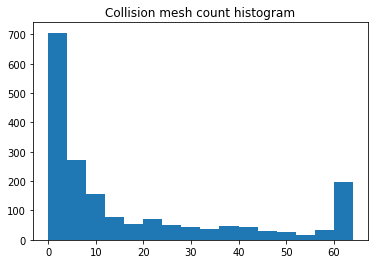

Median 7.0
Mean 24.502412868632707
Std 52.193649727970296
Max 954
Min 0


In [99]:
a = np.array(list(o_directives.values()))
display_stats(a, "Collision mesh count histogram")

## Analyze bounding box volumes

In [91]:
col_vols = {}
vis_vols = {}
bb_volume_ratios = {}
bb_max_nonzero_dim_ratios = {}
filtered_objs = collision_objs  # [x for x in collision_objs if "floors" in x]
watertight = 0
for col_name in tqdm(filtered_objs):
    col_name = pathlib.Path(col_name)
    target = col_name.parts[-5] + "-" + col_name.parts[-4]
    vis_name = pathlib.Path(str(col_name).replace("collision", "visual"))
    col_mesh = trimesh.load(col_name, force="mesh", skip_material=True)
    vis_mesh = trimesh.load(vis_name, force="mesh", skip_material=True, merge_tex=True, merge_norm=True)
    if vis_mesh.is_volume:
        watertight += 1
    
    col_bb = col_mesh.bounding_box.extents
    vis_bb = vis_mesh.bounding_box.extents
    
    col_vol = np.product(col_bb)
    vis_vol = np.product(vis_bb)
    
    col_vols[target] = col_vol
    vis_vols[target] = vis_vol
    bb_volume_ratios[target] = col_vol / vis_vol
    
    dim_ratio = col_bb / vis_bb
    invalid_dims = np.isclose(vis_bb, 0, atol=1e-3)
    if np.all(invalid_dims):
        print(f"Error: {target} bb's all dimensions are close to zero, can't include it:", vis_bb)
        continue
    elif np.any(invalid_dims):
        print(f"Warning: {target} bb has dimension close to zero:", vis_bb)
    bb_max_nonzero_dim_ratios[target] = np.max(dim_ratio[~invalid_dims])

  0%|          | 0/2492 [00:00<?, ?it/s]

C:\Users\Cem\AppData\Local\Temp\ipykernel_32988\1049509059.py:24: RuntimeWarning: divide by zero encountered in double_scalars
  bb_volume_ratios[target] = col_vol / vis_vol
C:\Users\Cem\AppData\Local\Temp\ipykernel_32988\1049509059.py:26: RuntimeWarning: divide by zero encountered in true_divide
  dim_ratio = col_bb / vis_bb


Error: bean-mfkwzi bb's all dimensions are close to zero, can't include it: [0.0002 0.0002 0.0002]
Error: walnut-nzqier bb's all dimensions are close to zero, can't include it: [0.0006 0.0007 0.0006]
Error: bean-cdinsu bb's all dimensions are close to zero, can't include it: [0.0002 0.0002 0.0002]


In [92]:
print("Total", len(filtered_objs))
print("Watertight", watertight)
print("Ratio", watertight / len(filtered_objs))

Total 2492
Watertight 768
Ratio 0.30818619582664525


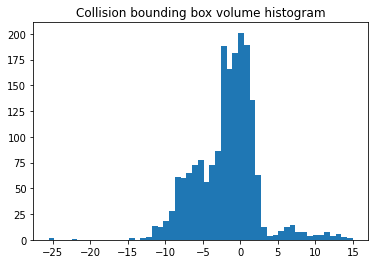

Median -1.4587954697897685
Mean -1.7750037284893985
Std 4.17633306187687
Max 14.997523930347594
Min -25.54418901770333


In [93]:
a = np.array(list(col_vols.values()))
display_stats(np.log(a), "Collision bounding box volume histogram")

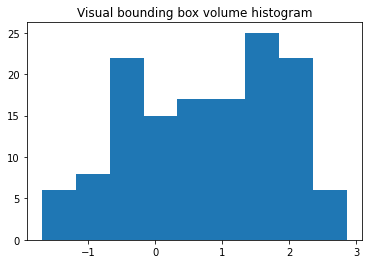

Median 0.968187506031601
Mean 0.7801856162950185
Std 1.1039477987148885
Max 2.8577349722046033
Min -1.6845982781597286


In [28]:
a = np.array(list(vis_vols.values()))
display_stats(np.log(a), "Visual bounding box volume histogram")

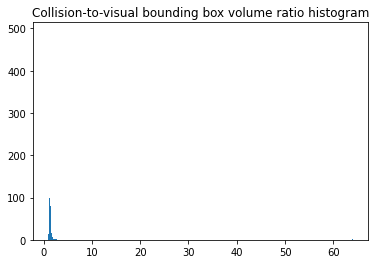

Median 1.13626829263237
Mean inf
Std nan
Max inf
Min 0.968481251697957


C:\Users\Cem\.conda\envs\pipeline\lib\site-packages\numpy\core\_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


In [37]:
a = np.array(list(bb_volume_ratios.values()))
display_stats(a, "Collision-to-visual bounding box volume ratio histogram")

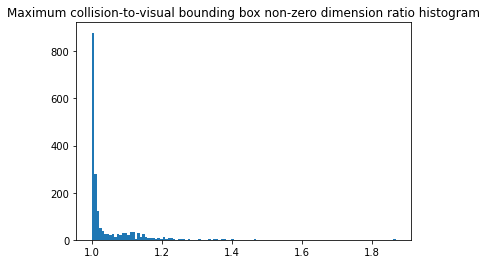

Median 1.0080048008455835
Mean 1.0411298202126682
Std 0.07867116557052281
Max 1.8692758620689658
Min 0.9999763147792707


In [94]:
a = np.array(list(bb_max_nonzero_dim_ratios.values()))
display_stats(a, "Maximum collision-to-visual bounding box non-zero dimension ratio histogram")

## Objects with too many links

In [ ]:
import sys
sys.path.append(r"D:\ig_pipeline")
from b1k_pipeline.utils import get_targets, PIPELINE_ROOT, parse_name

In [ ]:
import json
from collections import defaultdict
# Count the number of objects with non-tagged fixed links
link_cnts = {}
for target in tqdm.tqdm(get_targets("combined")):
    obj_list_file = PIPELINE_ROOT / "cad" / target / "artifacts" / "object_list.json"
    assert obj_list_file.exists(), "Missing obj list file " + str(obj_list_file)
    with open(obj_list_file, "r") as f:
        data = json.load(f)
        meshes = data["meshes"]
        parsed = [parse_name(x) for x in meshes]
        obj_link_cnts = defaultdict(set)
        for p in parsed:
            if not p.group("link_name") or p.group("link_name") == "base_link":
                continue
            if p.group("bad"):
                continue
            obj_name = p.group("obj_basename")
            link_name = p.group("link_basename")
            # Don't count openable links
            if p.group("tag") and "openable" in p.group("tag"):
                continue
            obj_link_cnts[obj_name].add(link_name)
        # fixed = sum(1 for x in parsed if x is not None and x.group("joint_type") == "F" and not x.group("tag"))
        link_cnts.update({x: len(y) for x, y in obj_link_cnts.items()})

In [ ]:
interesting = np.asarray(list(link_cnts.values()), dtype=int)
interesting = interesting[interesting>3]
display_stats(a, "Collision-to-visual bounding box volume ratio histogram")

In [ ]:
print("\n".join(str(x) for x in sorted(link_cnts.items(), key=lambda x: -x[1])))